In [1]:
import numpy
import keras
import sklearn
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [2]:
base_model = ResNet50(include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [3]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# === PATHS ===
train_dir =  r'E:\Dataset\Brain_Tumor_Classification\Training'
test_dir  = r'E:\Dataset\Brain_Tumor_Classification\Testing'
img_size  = (224, 224)   # same size you used in your model

# === Helper function ===
def load_dataset(data_dir, img_size):
    X, y = [], []
    classes = sorted(os.listdir(data_dir))
    for label in classes:
        class_path = os.path.join(data_dir, label)
        if not os.path.isdir(class_path):
            continue
        print(f"📂 Loading class: {label}")
        for file in tqdm(os.listdir(class_path), desc=f"{label}"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, file)
                try:
                    img = load_img(img_path, target_size=img_size, color_mode='rgb')
                    img_array = img_to_array(img) / 255.0   # normalize 0–1
                    X.append(img_array)
                    y.append(label)
                except Exception as e:
                    print(f"⚠️ Skipped {img_path} due to error: {e}")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Train and Test sets ===
X_train, y_train = load_dataset(train_dir, img_size)
X_test,  y_test  = load_dataset(test_dir, img_size)

print(f"\n✅ X_train shape: {X_train.shape}")
print(f"✅ y_train shape: {y_train.shape}")
print(f"✅ X_test shape:  {X_test.shape}")


📂 Loading class: glioma_tumor


glioma_tumor: 100%|██████████| 826/826 [00:06<00:00, 133.16it/s]


📂 Loading class: meningioma_tumor


meningioma_tumor: 100%|██████████| 822/822 [00:05<00:00, 155.14it/s]


📂 Loading class: no_tumor


no_tumor: 100%|██████████| 395/395 [00:02<00:00, 170.80it/s]


📂 Loading class: pituitary_tumor


pituitary_tumor: 100%|██████████| 827/827 [00:04<00:00, 183.38it/s]


📂 Loading class: glioma_tumor


glioma_tumor: 100%|██████████| 100/100 [00:01<00:00, 92.04it/s]


📂 Loading class: meningioma_tumor


meningioma_tumor: 100%|██████████| 115/115 [00:01<00:00, 96.94it/s]


📂 Loading class: no_tumor


no_tumor: 100%|██████████| 105/105 [00:00<00:00, 110.33it/s]


📂 Loading class: pituitary_tumor


pituitary_tumor: 100%|██████████| 74/74 [00:01<00:00, 70.67it/s]



✅ X_train shape: (2870, 224, 224, 3)
✅ y_train shape: (2870,)
✅ X_test shape:  (394, 224, 224, 3)


In [4]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test  = label_encoder.transform(y_test)

print("Classes found:", label_encoder.classes_)


Classes found: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [5]:
y_train


array([0, 0, 0, ..., 3, 3, 3])

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Suppose your labels are in a numpy array: y_train
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))


In [7]:

class_weight_dict


{0: np.float64(0.8686440677966102),
 1: np.float64(0.8728710462287105),
 2: np.float64(1.8164556962025316),
 3: np.float64(0.8675937122128174)}

In [8]:
class_weight_dict = {k: np.float32(v) for k, v in class_weight_dict.items()}
class_weight_dict

{0: np.float32(0.86864406),
 1: np.float32(0.87287104),
 2: np.float32(1.8164557),
 3: np.float32(0.8675937)}

In [9]:
## Compile the model ###

from tensorflow.keras.optimizers import Adam


model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])


In [10]:
## Train the model ###

model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    batch_size=32,
    shuffle=True
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 817s 9s/step - accuracy: 0.7375 - loss: 0.6871 - val_accuracy: 0.2589 - val_loss: 1.8829
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 745s 8s/step - accuracy: 0.9622 - loss: 0.1087 - val_accuracy: 0.2665 - val_loss: 3.9787
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 792s 9s/step - accuracy: 0.9914 - loss: 0.0279 - val_accuracy: 0.2640 - val_loss: 3.7433
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 790s 9s/step - accuracy: 0.9912 - loss: 0.0228 - val_accuracy: 0.2716 - val_loss: 3.9574
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 975s 11s/step - accuracy: 0.9833 - loss: 0.0427 - val_accuracy: 0.2665 - val_loss: 3.6710
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 716s 8s/step - accuracy: 0.9967 - loss: 0.0152 - val_accuracy: 0.2716 - val_loss: 6.1939
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 715s 8s/step - accuracy: 0.9978 - loss: 0.0078 - val_accuracy: 0.2944 - val_loss: 5.6910
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 790s 9s/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.2868 - 

In [11]:
for layer in model.layers:
    print(f"Layer: {layer.name}")



Layer: input_layer
Layer: conv1_pad
Layer: conv1_conv
Layer: conv1_bn
Layer: conv1_relu
Layer: pool1_pad
Layer: pool1_pool
Layer: conv2_block1_1_conv
Layer: conv2_block1_1_bn
Layer: conv2_block1_1_relu
Layer: conv2_block1_2_conv
Layer: conv2_block1_2_bn
Layer: conv2_block1_2_relu
Layer: conv2_block1_0_conv
Layer: conv2_block1_3_conv
Layer: conv2_block1_0_bn
Layer: conv2_block1_3_bn
Layer: conv2_block1_add
Layer: conv2_block1_out
Layer: conv2_block2_1_conv
Layer: conv2_block2_1_bn
Layer: conv2_block2_1_relu
Layer: conv2_block2_2_conv
Layer: conv2_block2_2_bn
Layer: conv2_block2_2_relu
Layer: conv2_block2_3_conv
Layer: conv2_block2_3_bn
Layer: conv2_block2_add
Layer: conv2_block2_out
Layer: conv2_block3_1_conv
Layer: conv2_block3_1_bn
Layer: conv2_block3_1_relu
Layer: conv2_block3_2_conv
Layer: conv2_block3_2_bn
Layer: conv2_block3_2_relu
Layer: conv2_block3_3_conv
Layer: conv2_block3_3_bn
Layer: conv2_block3_add
Layer: conv2_block3_out
Layer: conv3_block1_1_conv
Layer: conv3_block1_1_bn

In [12]:
img = X_test[100]
img_array = np.expand_dims(img, axis=0)
img_array.shape
pred = model.predict(img_array)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.02290109, 0.11195549, 0.86062753, 0.00451589]], dtype=float32)

In [13]:
y_test[100]

np.int64(1)

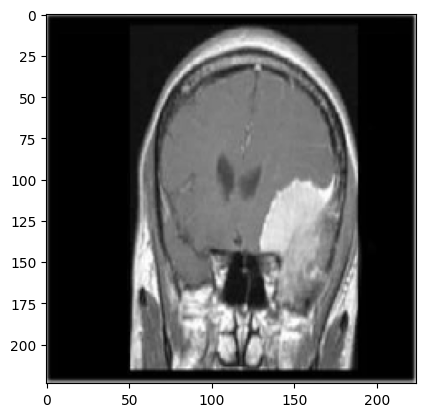

In [14]:
import matplotlib.pyplot as plt

plt.imshow(X_test[100])

In [15]:
cam_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_3_conv').output)

In [24]:
feature_maps = cam_model.predict(img_array)
feature_maps.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


(1, 7, 7, 2048)

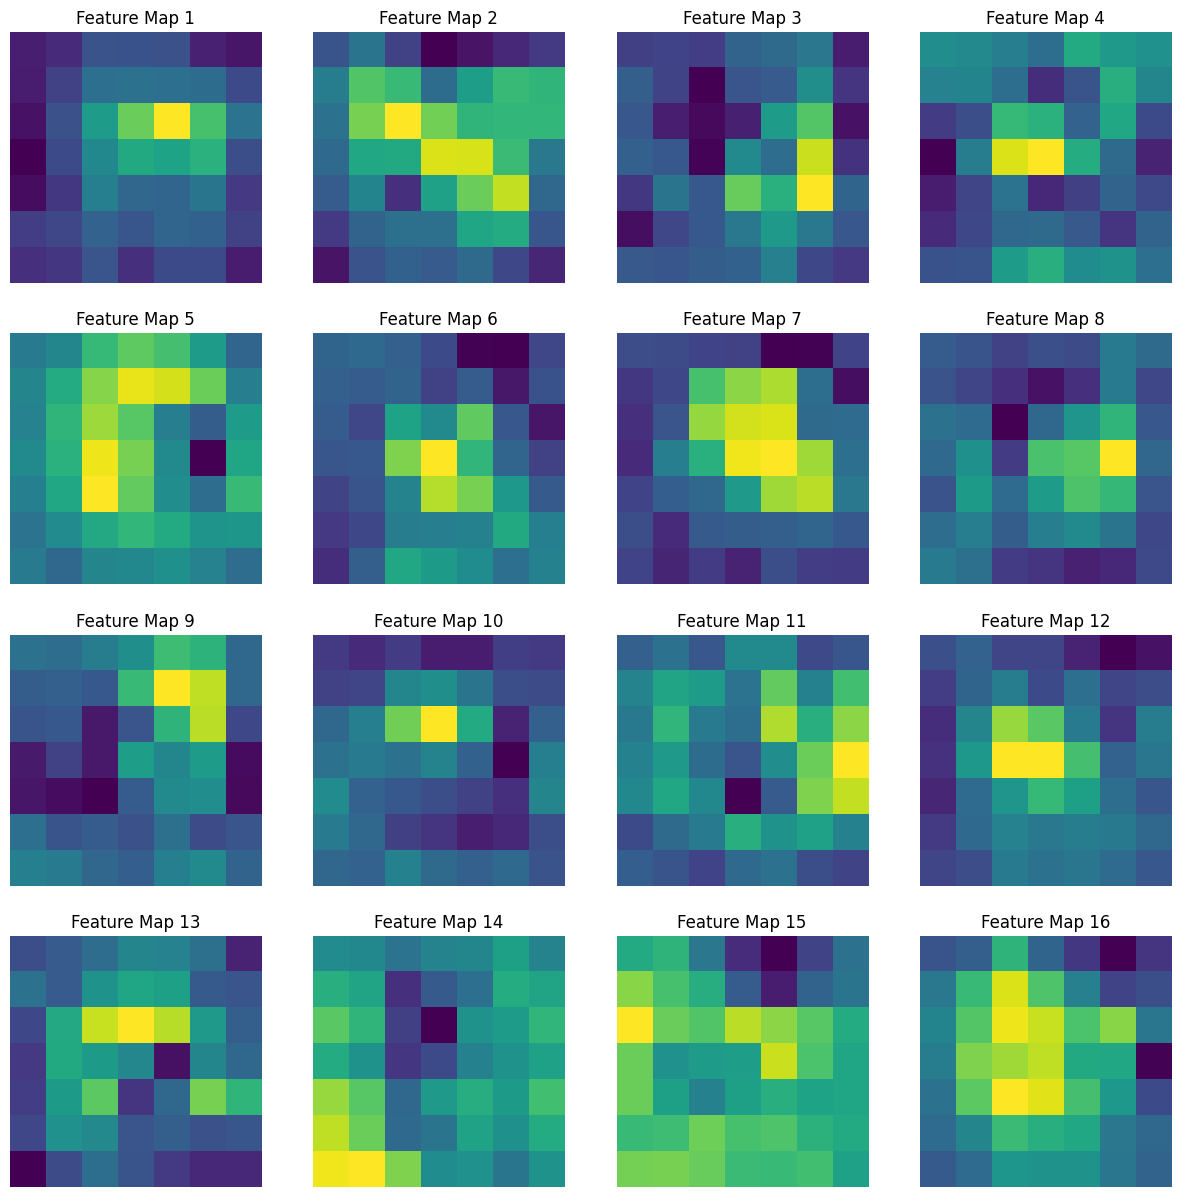

In [25]:
import matplotlib.pyplot as plt

# Remove batch dimension: shape (7, 7, 2048)
feature_maps = feature_maps[0]         # this is done to remove batch size

# Number of maps to show (e.g., first 16)
num_maps = 16

plt.figure(figsize=(15, 15))
for i in range(num_maps):
    plt.subplot(4, 4, i + 1)
    plt.imshow(feature_maps[:, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Feature Map {i+1}')
plt.show()


In [26]:
feature_maps.shape

(7, 7, 2048)

In [27]:
conv_layer = model.get_layer('dense')  # Use the appropriate layer name
weights, biases = conv_layer.get_weights()
print("Weights shape:", weights.shape)
print("Biases shape:", biases.shape)

Weights shape: (2048, 4)
Biases shape: (4,)


In [28]:
biases

array([-0.00036088,  0.00092332, -0.00063223, -0.00055699], dtype=float32)

In [29]:
class_index = 1
class_weights = weights[:, class_index]   # shape will be (2048,)


class_weights.shape

(2048,)

(7, 7)


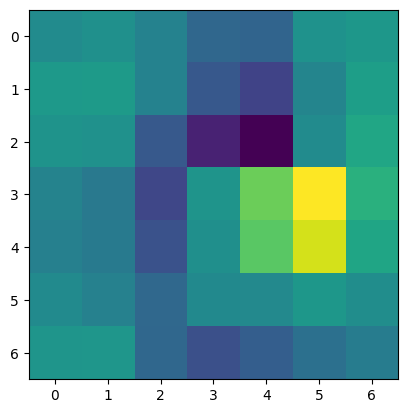

In [30]:
import numpy as np

# feature_maps: shape (7, 7, 2048)
# class_weights: shape (2048,)

cam_map = np.tensordot(feature_maps, class_weights, axes=([2], [0]))
# cam_map shape: (7, 7)
print(cam_map.shape)
plt.imshow(cam_map)

In [31]:
# Resize CAM to original image size


import cv2

# cam_map shape: (7, 7)
original_height, original_width = 224, 224

# Resize CAM to original image size
cam_resized = cv2.resize(cam_map, (original_width, original_height))

# Normalize between 0 and 1 for visualization
cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())


In [36]:
# Convert to heatmap
# cm is colormap, it can be of various types 'jet', 'viridis', 'hot', 'cool', 'magma'.

import matplotlib.cm as cm

heatmap = cm.jet(cam_resized)[:, :, :3]   # Drop alpha channel


In [37]:
# Overlay heatmap on image


alpha = 0.4  # transparency
original_img = X_test[100]

overlayed_img = alpha * heatmap + (1 - alpha) * original_img
overlayed_img = np.clip(overlayed_img, 0, 1)


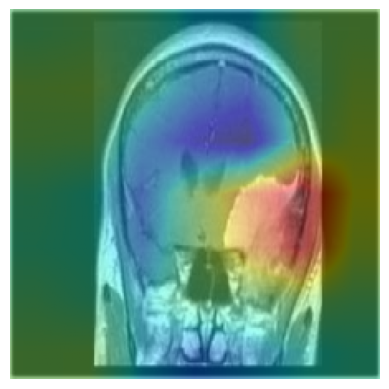

In [38]:
import matplotlib.pyplot as plt

plt.imshow(overlayed_img)
plt.axis('off')
plt.show()


### Grad-CAM Heatmap Generation ###

In [133]:
img = X_test[100]
img_array = np.expand_dims(img, axis=0)

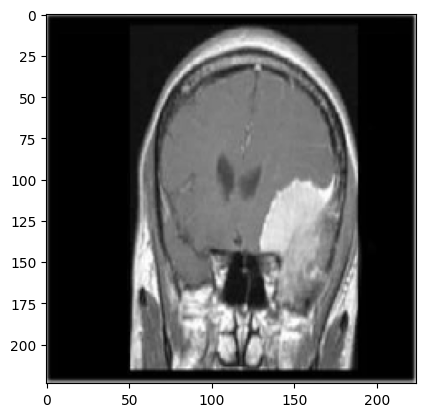

In [94]:
plt.imshow(img)

In [104]:
last_conv_layer_name = 'conv5_block3_3_conv' 

grad_model = tf.keras.models.Model(
    [model.inputs], 
    [model.get_layer(last_conv_layer_name).output, model.output])

In [105]:
last_conv_layer_output, preds = grad_model(img_array)

In [95]:
import tensorflow as tf

# 1. Create a model (grad_model) that maps the input to both last conv activations and predictions
last_conv_layer_name = 'conv5_block3_3_conv'    # e.g., 'conv5_block3_3_conv'
grad_model = tf.keras.models.Model(
    [model.inputs], 
    [model.get_layer(last_conv_layer_name).output, model.output]
)

# 2. Run the forward pass within a GradientTape context
with tf.GradientTape() as tape:
    # Make sure the input has batch dimension
    last_conv_layer_output, preds = grad_model(img_array)
    # Target index for the class (e.g., top predicted)
    class_index = tf.argmax(preds[0])    # or set manually
    class_channel = preds[:, class_index]
    
    # Watch the conv layer output for gradient computation
    tape.watch(last_conv_layer_output)

    # 3. Compute gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)  # SHAPE: (1, H, W, C)

# Now, 'grads' holds the gradient of the class score w.r.t. last conv layer activations


f:\Anaconda\envs\new_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [106]:
grads

<tf.Tensor: shape=(1, 7, 7, 2048), dtype=float32, numpy=
array([[[[-0.        ,  0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        ,  0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        ,  0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         ...,
         [-0.        ,  0.        , -0.        , ..., -0.        ,
          -0.00103958, -0.        ],
         [-0.        ,  0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        ,  0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ]],

        [[-0.        ,  0.00035653, -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        ,  0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        ,  0.        , -0.        , ..., -0.0009932 ,
          -0.00103958, -0.  

In [107]:
# Compute channel-wise mean of gradients (global average pooling)
weights = tf.reduce_mean(grads, axis=(0, 1, 2))

In [108]:
weights

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([-1.8286132e-04,  3.6381058e-05, -5.7662757e-05, ...,
       -2.8377175e-04, -2.9702391e-04, -3.2889577e-05], dtype=float32)>

In [111]:
last_conv_layer_output

<tf.Tensor: shape=(1, 7, 7, 2048), dtype=float32, numpy=
array([[[[-1.64041579e-01, -1.28975123e-01, -1.37708068e-01, ...,
          -9.94247720e-02, -8.69478062e-02, -9.19557437e-02],
         [-1.49118409e-01, -1.08040102e-01, -1.34914190e-01, ...,
          -9.24648270e-02, -9.26474407e-02, -9.81356800e-02],
         [-9.43647400e-02, -1.39144629e-01, -1.39642730e-01, ...,
          -3.60133499e-02,  1.57167036e-02, -7.31458068e-02],
         ...,
         [-9.77049246e-02, -1.63233891e-01, -1.02771126e-01, ...,
           5.45812026e-02,  2.61442602e-01, -6.52630553e-02],
         [-1.61620691e-01, -1.53248236e-01, -9.16313827e-02, ...,
          -1.84388179e-02,  1.11387722e-01, -7.43824318e-02],
         [-1.74372151e-01, -1.43894061e-01, -1.62138835e-01, ...,
          -6.04313985e-02, -2.65109986e-02, -6.91220537e-02]],

        [[-1.66455328e-01, -1.01485327e-01, -1.12804174e-01, ...,
          -7.91670978e-02, -1.06873520e-01, -1.12555057e-01],
         [-1.19241782e-01, -4.9

In [119]:
heatmap = np.tensordot(last_conv_layer_output[0], weights, axes=([2], [0]))
heatmap

array([[-1.8107141e-03, -1.9642124e-03, -1.0143332e-03, -6.1654154e-04,
        -1.5576978e-03, -2.2661800e-03, -1.9824854e-03],
       [-1.3194585e-03, -1.2208254e-03, -2.3558782e-04, -1.4568566e-03,
        -2.4882485e-03, -3.1571055e-03, -1.7692334e-03],
       [-7.3488720e-04, -4.8274023e-04,  5.0558505e-04,  3.5758491e-04,
        -1.0488497e-05, -2.8055252e-03, -1.3263775e-03],
       [-7.4604398e-04, -8.7741576e-04, -4.9822067e-04, -3.1656242e-04,
        -1.1670904e-04, -1.8240440e-03, -9.3250565e-05],
       [-1.1694597e-04, -5.4901699e-04, -5.4705131e-04,  1.1753410e-03,
         1.4026233e-03,  1.1996594e-03,  8.1815233e-04],
       [-1.5912973e-04, -9.5776451e-04, -8.7098079e-04, -7.0287392e-04,
        -9.8009594e-05, -3.2819225e-05, -2.4287187e-04],
       [-7.1660348e-04, -1.1385845e-03, -1.4369443e-04, -3.1022052e-04,
        -1.1765567e-04, -3.0250277e-04, -6.8015413e-04]], dtype=float32)

In [120]:
# Apply ReLU to keep only positive influence
heatmap = tf.nn.relu(heatmap)
heatmap.shape

TensorShape([7, 7])

(7, 7)


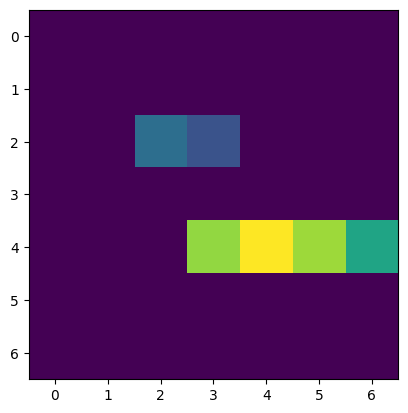

In [123]:
# Normalize heatmap between 0 and 1
heatmap = heatmap / tf.reduce_max(heatmap)
plt.imshow(heatmap)
print(heatmap.shape)

In [131]:
heatmap_numpy = heatmap.numpy()


In [132]:
# Resize Grad-CAM to original image size
import cv2

# cam_map shape: (7, 7)
original_height, original_width = (224, 224)

# Resize CAM to original image size
heatmap_resized = cv2.resize(heatmap_numpy, (original_width, original_height))


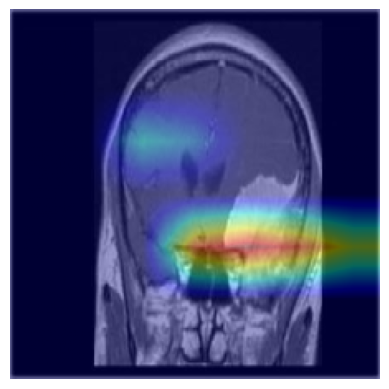

In [134]:
# Step 3: Use a color map (e.g., JET)
heatmap_jet = cm.jet(heatmap_resized)[:, :, :3]   # Drop alpha channel

### Overlay image  ###
alpha = 0.4

overlayed_img = alpha * heatmap_jet + (1 - alpha) * img
overlay = np.clip(overlayed_img, 0, 1)

# Display the result
plt.imshow(overlay)
plt.axis('off')
plt.show()